In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -n "../content/drive/MyDrive/data/image/dataset.zip" -d "../content/drive/MyDrive/data/image"

In [ ]:
!unzip -n "../content/drive/MyDrive/data/image/query.zip" -d "../content/drive/MyDrive/data/image"

## Hist

In [2]:
import cv2
import glob
import os, sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

In [3]:
DIR = "/content/drive/MyDrive/data/image"

def normalize_hist(target_dir):
  dataset_hist = []
  
  for path in glob.glob(os.path.join(DIR, target_dir, "*.jpg")):
    img = cv2.imread(path, 0)
    img_hist = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    dataset_hist.append(img_hist)

  dataset_hist = normalize(np.array(dataset_hist))

  return dataset_hist

    

In [4]:
dataset_hist = normalize_hist(target_dir="dataset")
query_hist = normalize_hist(target_dir="query")

In [5]:
# Calculate the color histogram similarity
dis = np.dot(query_hist, dataset_hist.T)
dataset_path = np.array(glob.glob('/content/drive/MyDrive/data/image/dataset/*.jpg'))

In [11]:
print("Dataset: ", dataset_hist.shape)
print("Query: ", query_hist.shape)

Dataset:  (11139, 256)
Query:  (2500, 256)


In [17]:
# Calculate the color histogram similarity
dis = np.dot(query_hist, dataset_hist.T) #shape: [2500, 11139]
dataset_path = np.array(glob.glob('/content/drive/MyDrive/data/image/dataset/*.jpg'))

pd.DataFrame({
    'source': [x.split('/')[-1] for x in dataset_path[dis.argmax(1)]],
    'query': [x.split('/')[-1] for x in glob.glob('/content/drive/MyDrive/data/image/query/*.jpg')]
}).to_csv('submit1_hist.csv', index=None)

In [20]:
dis

array([[0.65317774, 0.64039123, 0.5783112 , ..., 0.8527442 , 0.61847997,
        0.7970309 ],
       [0.5625756 , 0.6264372 , 0.50759697, ..., 0.55917966, 0.56594867,
        0.64089996],
       [0.28293395, 0.2851452 , 0.30199194, ..., 0.37188736, 0.27783355,
        0.26652515],
       ...,
       [0.28881618, 0.46399063, 0.236657  , ..., 0.2791168 , 0.21969387,
        0.42211685],
       [0.30125457, 0.27332458, 0.21951117, ..., 0.31233287, 0.2135972 ,
        0.29123956],
       [0.31786188, 0.27259493, 0.32663926, ..., 0.42486683, 0.2849834 ,
        0.30763352]], dtype=float32)

## ORB

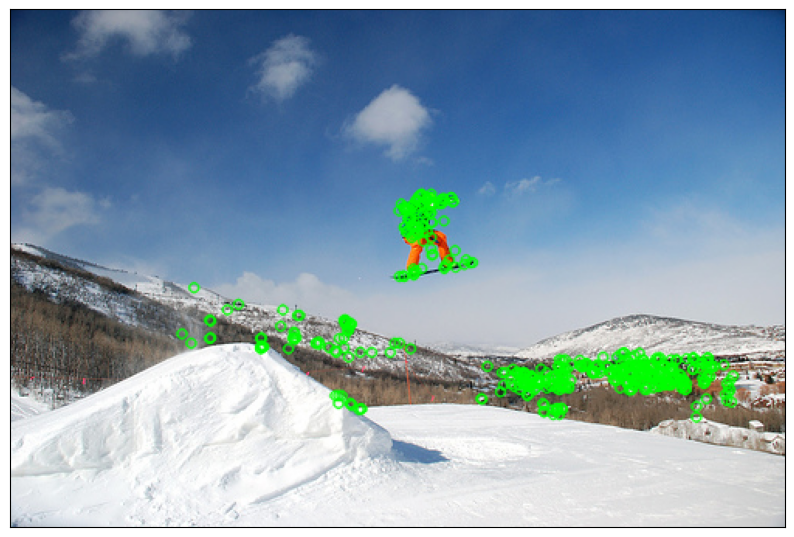

In [48]:
import matplotlib.pyplot as plt
import pdb

def ORB(img):
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(img, None)

    # draw the keypoints
    img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.imshow(img2[:, :, ::-1]) # BGR to RGB
    plt.xticks([]), plt.yticks([])
    plt.show()
    return kp, des

 
random_idx = np.random.randint(0,len(dataset_path)+1, size=1)
test_img = cv2.imread(dataset_path[int(random_idx)])
kp1, des1 = ORB(test_img)

In [ ]:

import cv2
import glob
import os, sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

df = pd.read_csv('submit.csv')
query_path = df['query'].values
source_path = df['source'].values

sift = cv2.SIFT_create()
orb = cv2.ORB_create()

bf = cv2.BFMatcher()

dataset_feat = []
for path in glob.glob('./dataset/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    dataset_feat.append(feat)

dataset_feat = np.array(dataset_feat)
dataset_feat = normalize(dataset_feat)

query_feat = []
for path in glob.glob('./query/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    query_feat.append(feat)

query_feat = np.array(query_feat)
query_feat = normalize(query_feat)

dis = np.dot(query_feat, dataset_feat.T)
dataset_path = np.array(glob.glob('./dataset/*.jpg'))

top10_index = dis.argsort(1)[:, -10:]

result_sift = []
result_orb = []
for i in range(len(query_path)):
    query_img = cv2.imread(os.path.join('./query', query_path[i]), 0)
    
    query_kp_sift, query_des_sift = sift.detectAndCompute(query_img, None)
    
    query_kp_orb, query_des_orb = orb.detectAndCompute(query_img, None)
    
    max_matches_sift = 0
    best_index_sift = -1
    
    max_matches_orb = 0
    best_index_orb = -1
    
    for j in top10_index[i]:
        dataset_img = cv2.imread(dataset_path[j], 0)
        
        dataset_kp_sift, dataset_des_sift = sift.detectAndCompute(dataset_img, None)
        
        dataset_kp_orb, dataset_des_orb = orb.detectAndCompute(dataset_img, None)
        
        matches_sift = bf.match(query_des_sift, dataset_des_sift)
        matches_orb = bf.match(query_des_orb, dataset_des_orb)
        
        matches_num_sift = len(matches_sift)
        matches_num_orb = len(matches_orb)
        
        if matches_num_sift > max_matches_sift:
            max_matches_sift = matches_num_sift
            best_index_sift = j
        
        if matches_num_orb > max_matches_orb:
            max_matches_orb = matches_num_orb
            best_index_orb = j
    
    if best_index_sift != -1:
        result_sift.append(dataset_path[best_index_sift].split('/')[-1])
    else:
        result_sift.append('None')
    
    if best_index_orb != -1:
        result_orb.append(dataset_path[best_index_orb].split('/')[-1])
    else:
        result_orb.append('None')

df_sift = pd.DataFrame({'query': query_path, 'source': result_sift})
df_sift.to_csv('submit_sift.csv', index=False)

df_orb = pd.DataFrame({'query': query_path, 'source': result_orb})
df_orb.to_csv('submit_orb.csv', index=False)

In [ ]:



# 使用sift或orb提取图片的关键点，对对提取的关键点进行匹配。
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

results = []
for i in range(dis.shape[0]):
    query_img_path = glob.glob('./query/*.jpg')[i]
    query_img = cv2.imread(query_img_path)
    kp1, des1 = sift.detectAndCompute(query_img,None)

    top10_idx = dis[i].argsort()[-10:][::-1]
    top10_path = dataset_path[top10_idx]

    max_match_num = 0
    max_match_path = ''
    for path in top10_path:
        img2 = cv2.imread(path)
        kp2, des2 = sift.detectAndCompute(img2,None)
        matches = bf.knnMatch(des1,des2,k=2)
        good_matches = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good_matches.append(m)
        if len(good_matches) > max_match_num:
            max_match_num = len(good_matches)
            max_match_path = path

    results.append(max_match_path.split('/')[-1])

pd.DataFrame({
    'source': results,
    'query': [x.split('/')[-1] for x in glob.glob('./query/*.jpg')]
}).to_csv('submit.csv', index=None)


In [ ]:


以下是任务2的代码，其中使用了ORB特征提取和FLANN匹配器进行关键点匹配：

```python
import cv2
import glob
import os
import pandas as pd
import numpy as np

# 创建ORB特征检测器和描述符
orb = cv2.ORB_create()

# FLANN匹配器参数
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=1)
search_params = dict(checks=100)

# 计算dataset文件夹中所有图像的ORB特征描述符
dataset_des = []
dataset_path = np.array(glob.glob('./dataset/*.jpg'))
for path in dataset_path:
    img = cv2.imread(path, 0)
    _, des = orb.detectAndCompute(img, None)
    dataset_des.append(des)

# FLANN匹配器
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 计算query文件夹中所有图像的ORB特征描述符
query_des = []
query_path = np.array(glob.glob('./query/*.jpg'))
for path in query_path:
    img = cv2.imread(path, 0)
    _, des = orb.detectAndCompute(img, None)
    query_des.append(des)

# 计算query和dataset中所有的直方图特征
dataset_feat = []
for path in glob.glob('./dataset/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    dataset_feat.append(feat)

query_feat = []
for path in glob.glob('./query/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    query_feat.append(feat)

# 进行归一化
dataset_feat = np.array(dataset_feat)
dataset_feat = normalize(dataset_feat)

query_feat = np.array(query_feat)
query_feat = normalize(query_feat)

# 对query每张图计算与其对应的Top10相似的dataset图
submit = []
for i, des in enumerate(query_des):
    # FLANN匹配器
    matches = flann.knnMatch(des, np.array(dataset_des), k=2)

    # 根据Lowe's ratio test进行过滤
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # 根据匹配的关键点数目进行排序并选择最相似的Top10图
    match_counts = np.zeros(len(dataset_des))
    for m in good_matches:
        match_counts[m.imgIdx] += 1

    top10 = dataset_path[np.argsort(-match_counts)[:10]]

    # 对每个Top10图使用sift或orb进行过滤，选择匹配关键点最多的作为结果
    best_match_count = 0
    best_match_path = ''
    for path in top10:
        img = cv2.imread(path, 0)
        _, des = orb.detectAndCompute(img, None)

        matches = flann.knnMatch(des, np.array([query_des[i]]), k=2)
        good_matches = []
        for m, n in matches:

In [ ]:
# 使用orb和sift提取图片的关键点，对对提取的关键点进行匹配。
import cv2
import glob
import os, sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# 读取任务1的结果
df = pd.read_csv('submit.csv')
query_path = df['query'].values
source_path = df['source'].values

# 创建sift和orb对象
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

# 创建匹配器对象
bf = cv2.BFMatcher()

# 计算query和dataset中所有的直方图特征
dataset_feat = []
for path in glob.glob('./dataset/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    dataset_feat.append(feat)

# 进行归一化
dataset_feat = np.array(dataset_feat)
dataset_feat = normalize(dataset_feat)

query_feat = []
for path in glob.glob('./query/*.jpg'):
    img = cv2.imread(path, 0)
    feat = cv2.calcHist(np.array([img]), [0], None, [256], [0, 256]).flatten()
    query_feat.append(feat)

# 进行归一化
query_feat = np.array(query_feat)
query_feat = normalize(query_feat)

# 计算每张query图片与dataset图片的颜色直方图相似度
dis = np.dot(query_feat, dataset_feat.T)
dataset_path = np.array(glob.glob('./dataset/*.jpg'))

# 对每张query图片，找到与其最相似的10张dataset图片
top10_index = dis.argsort(1)[:, -10:]

# 对每个Top10图使用sift或orb进行过滤，选择匹配关键点最多的作为结果
result_sift = [] # 存储使用sift方法得到的结果
result_orb = [] # 存储使用orb方法得到的结果
for i in range(len(query_path)):
    # 读取query图片
    query_img = cv2.imread(os.path.join('./query', query_path[i]), 0)
    
    # 使用sift提取query图片的关键点和描述符
    query_kp_sift, query_des_sift = sift.detectAndCompute(query_img, None)
    
    # 使用orb提取query图片的关键点和描述符
    query_kp_orb, query_des_orb = orb.detectAndCompute(query_img, None)
    
    # 初始化最大匹配数和最佳索引（分别对应sift和orb）
    max_matches_sift = 0
    best_index_sift = -1
    
    max_matches_orb = 0
    best_index_orb = -1
    
    # 遍历Top10图片
    for j in top10_index[i]:
        # 读取dataset图片
        dataset_img = cv2.imread(dataset_path[j], 0)
        
        # 使用sift提取dataset图片的关键点和描述符
        dataset_kp_sift, dataset_des_sift = sift.detectAndCompute(dataset_img, None)
        
        # 使用orb提取dataset图片的关键点和描述符
        dataset_kp_orb, dataset_des_orb = orb.detectAndCompute(dataset_img, None)
        
        # 使用匹配器对象进行匹配，返回匹配对列表（分别对应sift和orb）
        matches_sift = bf.match(query_des_sift, dataset_des_sift)
        matches_orb = bf.match(query_des_orb, dataset_des_orb)
        
        # 统计匹配对的数量（分别对应sift和orb）
        matches_num_sift = len(matches_sift)
        matches_num_orb = len(matches_orb)
        
        # 如果匹配对数量大于当前最大匹配数，